# <center> Оценки отелей на Booking
## Постановка задачи

Построение модели, которая предсказывает рейтинг отеля.


В каждом исследовании уровень значимости $\alpha=0.05$.

## Данные
- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, - сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.


In [29]:
# Загрузка библиотек
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns
 
import nltk   
import scipy.stats as stats
import re
%matplotlib inline

In [30]:
# фиксируем RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы:
RANDOM_SEED = 42

In [31]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt  x

In [32]:
# Подгрузим данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample = pd.read_csv('submissiion.csv') # самбмишн

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [34]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [35]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [36]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_test, df_train], ignore_index=True, sort=False)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [38]:
data.nunique() #поиск уникальных значений

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1472
lng                                             1472
sample                                             2
reviewer_score                                    38
dtype: int64

In [39]:
data.describe() # описание числовых признаков

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


In [40]:
data.describe(include=['object']) # описание признаков типа 'object' 

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


## Очистка данных


In [41]:
num_duplicates = data.duplicated().sum()  # считаем количество дубликатов

# вывод количества дубликатов
print("Количество дубликатов: ", num_duplicates)

Количество дубликатов:  336


In [42]:
# проверяем дубликаты
data[data.duplicated ()]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
26726,Scarsdale Place Kensington Kensington and Chel...,1831,11/8/2016,8.1,Copthorne Tara Hotel London Kensington,United Kingdom,No Negative,0,7105,Location Breakfast,3,11,"[' Business trip ', ' Couple ', ' Standard Dou...",268 day,51.499046,-0.191707,0,0.0
49098,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,7/16/2017,7.9,H tel Concorde Montparnasse,United States of America,No Negative,0,2515,Good location for late night arrival by train...,29,2,"[' Leisure trip ', ' Family with young childre...",18 days,48.838108,2.318669,0,0.0
49541,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,4/9/2017,7.9,H tel Concorde Montparnasse,Lebanon,Elevator needs restoration Cleaning,5,2515,No Positive,0,12,"[' Leisure trip ', ' Solo traveler ', ' Classi...",116 day,48.838108,2.318669,0,0.0
50267,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,3/20/2016,9.0,H tel Baume,United States of America,No Negative,0,253,Great location Very pleasant clean and modern...,12,13,"[' Leisure trip ', ' Family with older childre...",501 day,48.850152,2.339278,0,0.0
51878,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,7/5/2017,7.9,H tel Concorde Montparnasse,Belgium,Absence of a proper fridge what they call min...,25,2515,Very comfy beds friendly and efficient recept...,9,9,"[' Leisure trip ', ' Solo traveler ', ' Classi...",29 days,48.838108,2.318669,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512039,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,11/3/2015,9.0,H tel Baume,United States of America,Rooms are very small,6,253,Location is excellent and staff is very frien...,10,1,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",639 day,48.850152,2.339278,1,8.3
512118,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,7/28/2016,7.9,H tel Concorde Montparnasse,France,A bit noisy old fashion At almost 20 the brea...,18,2515,Convenient if one arrives departs from the Mo...,10,48,"[' Business trip ', ' Solo traveler ', ' Class...",371 day,48.838108,2.318669,1,6.7
512733,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,5/15/2017,7.9,H tel Concorde Montparnasse,United Kingdom,twice spoken to staff to replace the coffee w...,24,2515,Tea making facilities not in the room only co...,11,2,"[' Leisure trip ', ' Couple ', ' Superior Doub...",80 days,48.838108,2.318669,1,7.9
513053,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,10/12/2015,7.9,H tel Concorde Montparnasse,Australia,No great restaurants within a short walk but ...,12,2515,The Hotel was wonderfully p laced for us to a...,44,24,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",661 day,48.838108,2.318669,1,10.0


Заметим, что данные дублируются не по всем столбцам,  удалять не будем.

In [43]:
# Поиск неинформативных признаков 
low_information_cols = [] 

for col in data.columns:
    top_freq = data[col].value_counts(normalize=True).max()
    nunique_ratio = data[col].nunique() / data[col].count()
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

Неинформативных признаков мы не нашли

Заметим,что имеются пропуски. Их одинаковое количество говорит, что они парные

In [44]:
# выведем адреса отелей, в которых отсутствуют координаты
unknown_locs = data[data['lat'].isnull()].groupby('hotel_address').count()[['lat', 'lng']]
unknown_locs

,lat,lng
hotel_address,,
20 Rue De La Ga t 14th arr 75014 Paris France,0,0
23 Rue Damr mont 18th arr 75018 Paris France,0,0
4 rue de la P pini re 8th arr 75008 Paris France,0,0
Bail n 4 6 Eixample 08010 Barcelona Spain,0,0
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,0,0
Hasenauerstra e 12 19 D bling 1190 Vienna Austria,0,0
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,0,0
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,0,0
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,0,0


In [45]:
# заполним недостающие координаты
locs = [[48.8399957, 2.3070823], 
           [48.8889127, 2.3309643], 
           [48.8753208, 2.3212033], 
           [41.391552, 2.1757053],
           [48.2208555, 16.3644228],
           [48.233592, 16.3434781],
           [48.2094054, 16.3512565],
           [48.2095525, 16.3492746],
           [48.1888183, 16.381591],
           [48.1868142, 16.418528],
           [41.3749946, 2.1102353],
           [48.219573, 16.2834034],
           [41.3832425, 2.1607609],
           [48.2458909, 16.3397395],
           [48.2135906, 16.3777195],
           [48.2168032, 16.357717],
           [48.220414, 16.3536299]]

for i in range (17):
    unknown_locs.iloc[i] = locs[i]
unknown_locs

C:\Users\Анастасия\AppData\Local\Temp\ipykernel_14592\2635743503.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '48.8399957' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  unknown_locs.iloc[i] = locs[i]
C:\Users\Анастасия\AppData\Local\Temp\ipykernel_14592\2635743503.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.3070823' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  unknown_locs.iloc[i] = locs[i]


,lat,lng
hotel_address,,
20 Rue De La Ga t 14th arr 75014 Paris France,48.839996,2.307082
23 Rue Damr mont 18th arr 75018 Paris France,48.888913,2.330964
4 rue de la P pini re 8th arr 75008 Paris France,48.875321,2.321203
Bail n 4 6 Eixample 08010 Barcelona Spain,41.391552,2.175705
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,48.220855,16.364423
Hasenauerstra e 12 19 D bling 1190 Vienna Austria,48.233592,16.343478
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,48.209405,16.351257
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,48.209553,16.349275
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,48.188818,16.381591


In [46]:
# заполним в датасете пропущенные координаты
data = data.set_index('hotel_address')
data.update(unknown_locs)
data = data.reset_index()

In [47]:
# проверим что пропусков не осталось
print(data[data['lat'].isna()].shape[0])
print(data[data['lng'].isna()].shape[0])

0
0


## Создание новых признаков

1. Изучим признак hotel_address (адрес отеля)


<Axes: ylabel='hotel_address'>

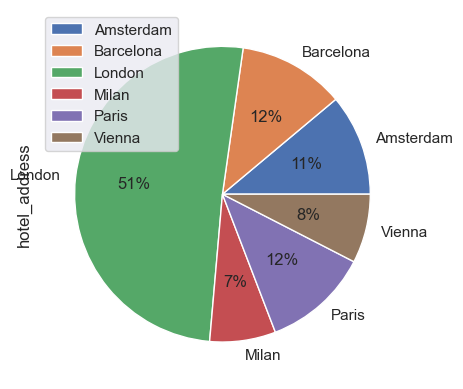

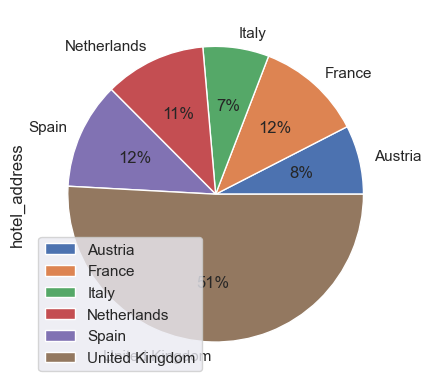

In [48]:
sns.set(font_scale = 1)
# создадим новый признак страны
data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1]\
                                            if x.split()[-1] != 'Kingdom'\
                                                    else ' '.join(x.split()[-2:]))
# создадим новый признак города 
data['city'] = data['hotel_address'].apply(lambda x: x.split()[-2]\
                                         if x.split()[-1] != 'Kingdom'\
                                         else x.split()[-5])
#Проверим соотношение городов и стран
data.groupby(['city']).count().plot( 
    kind='pie', y = 'hotel_address', autopct='%1.0f%%') 
data.groupby(['country']).count().plot( 
    kind='pie', y = 'hotel_address', autopct='%1.0f%%') 

Из показанных диаграмм, видно, что  все города являются стоицами. Это значит, что нам нужен только оди признак.
Оставим country


In [49]:
#Удаляем ненужные признаки об адресе отеля
data = data.drop(['hotel_address', 'city'], axis = 1)
data.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain


Посмотрим, как влияет страна на оценку отеля.

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'United Kingdom'),
  Text(1, 0, 'France'),
  Text(2, 0, 'Netherlands'),
  Text(3, 0, 'Italy'),
  Text(4, 0, 'Austria'),
  Text(5, 0, 'Spain')])

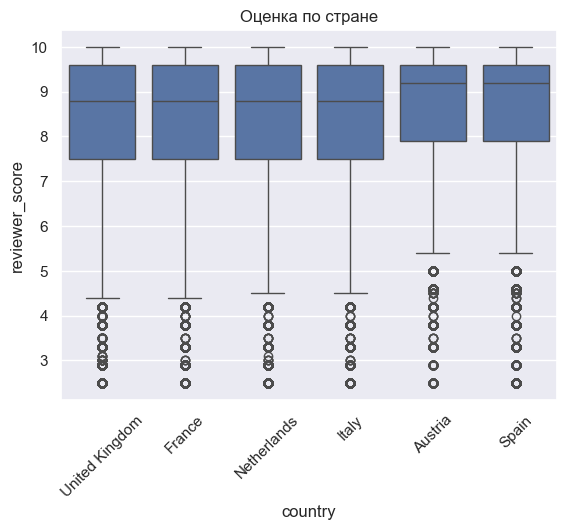

In [50]:

data = data[data['sample']==1]
    
sns.boxplot(y = 'reviewer_score', x = 'country', data=data).set(title = 'Оценка по стране')
plt.ylabel = 'Страна'
plt.xlabel = 'Выставленный рейтинг'
plt.xticks(rotation=45)



Различия имеются тоько с Austia и Spain.Преобразуем новый признак country так, чтобы он указывал на "Австрию-Испанию" и "Другое"ю

In [51]:
def spain_or_not(country):
    if country in ('Austria', 'Spain'):
        return 1
    return 0

data['Spain_Austria'] = data['country'].apply(spain_or_not)
data.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country,Spain_Austria
128935,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1,10.0,United Kingdom,0
128936,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1,6.3,United Kingdom,0
128937,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1,7.5,France,0


2. Изучим признак review_date 

In [52]:
# Превратим колонку даты в тип даты
data['review_date'] = pd.to_datetime(data['review_date'])
# возьмем день недели и месяц
data['review_day_of_week'] = data['review_date'].dt.day_of_week
data['review_month'] = data['review_date'].dt.month
data.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,tags,days_since_review,lat,lng,sample,reviewer_score,country,Spain_Austria,review_day_of_week,review_month
128935,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,...,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1,10.0,United Kingdom,0,4,2
128936,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,...,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1,6.3,United Kingdom,0,3,1
128937,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,...,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1,7.5,France,0,1,10


In [53]:
# Удалим колонку даты
data = data.drop(['review_date'], axis = 1)

Рассмотрим колонку -'Оценка по дням недели'

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6')])

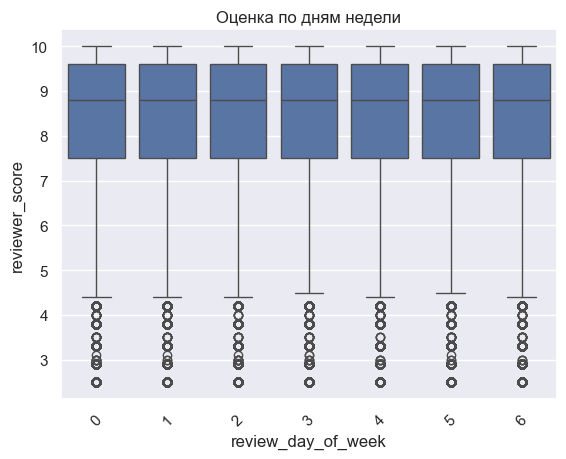

In [54]:
data[data['sample']==1]
sns.boxplot(y = 'reviewer_score', x = 'review_day_of_week', data=data).set(title = 'Оценка по дням недели')
plt.ylabel = 'День недели'
plt.xlabel = 'Выставленный рейтинг'
plt.xticks(rotation=45)


Кажется, что коробки одинаковы, но проверим это статистически. 

Критерий хи-квадрат.

Нулевая гипотеза: признаки независимы

Альтернативная гипотеза: признаки зависимы

Для удобства создадим функцию метода хи- квадрат, она нам ещё понадобится

In [55]:
#  функция для статистической проверки зависимости итогового признака от категориального признака методом хи-квадрат
# задаём уровень значимости
alpha = 0.05 

# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

def chi_2(data, column):
    df = data[data['sample'] == 1]
    table = pd.crosstab(df[column], df['reviewer_score'])

    _, p, _, _ = stats.chi2_contingency(table)
    decision_hypothesis(p)

In [56]:
chi_2(data, 'review_day_of_week')

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Оставляем признак дня недели.

Рассмотрим колонку

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

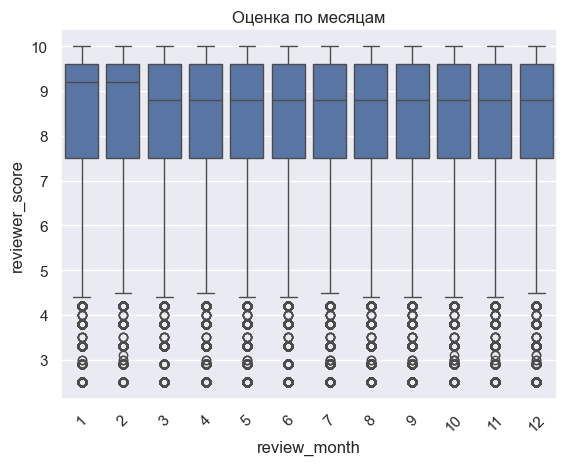

In [57]:
data[data['sample']==1]
sns.boxplot(y = 'reviewer_score', x = 'review_month', data=data).set(title = 'Оценка по месяцам')
plt.ylabel = 'Месяц'
plt.xlabel = 'Выставленный рейтинг'
plt.xticks(rotation=45)


Видно, что выставленная оценка слегка варьируется в зависимости от месяца. Проверим, может быть, она сильнее зависит от времени года?

In [58]:
def return_season(month):
    if month in (12, 1, 2):
        return 1
    elif month in (3, 4, 5):
        return 2
    elif month in (6, 7, 8):
        return 3
    return 4

data['season'] = data['review_month'].apply(return_season)
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,days_since_review,lat,lng,sample,reviewer_score,country,Spain_Austria,review_day_of_week,review_month,season
128935,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,531 day,51.507894,-0.143671,1,10.0,United Kingdom,0,4,2,1
128936,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,203 day,51.521009,-0.123097,1,6.3,United Kingdom,0,3,1,1
128937,32,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,...,289 day,48.845377,2.325643,1,7.5,France,0,1,10,4


([0, 1, 2, 3],
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

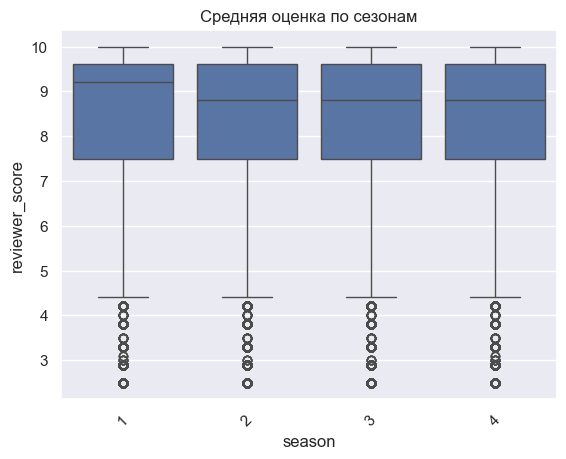

In [59]:
data[data['sample']==1]
sns.boxplot(y = 'reviewer_score', x = 'season', data=data).set(title = 'Средняя оценка по сезонам')
plt.ylabel = 'Сезон'
plt.xlabel = 'Выставленный рейтинг'
plt.xticks(rotation=45)


Зависимость от сезона прослеживается довольно слабо: имеет смысл, зима это или любой другой сезон. По предыдущему графику видно, что декабрь практически не отличается от других месяцев.

Поэтому сделаем так же, как и со страной: введем признак "январь-февраль" это или другой месяц.

In [60]:
def is_Jan(month):
    if month in (1, 2):
        return 1
    return 0

data['is_Jan_or_Feb'] = data['review_month'].apply(is_Jan)
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,lat,lng,sample,reviewer_score,country,Spain_Austria,review_day_of_week,review_month,season,is_Jan_or_Feb
128935,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,51.507894,-0.143671,1,10.0,United Kingdom,0,4,2,1,1
128936,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,51.521009,-0.123097,1,6.3,United Kingdom,0,3,1,1,1
128937,32,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,...,48.845377,2.325643,1,7.5,France,0,1,10,4,0


Удалим ненужные колонки

In [61]:
data = data.drop(['review_month', 'season'], axis=1)
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country,Spain_Austria,review_day_of_week,is_Jan_or_Feb
128935,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1,10.0,United Kingdom,0,4,1
128936,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1,6.3,United Kingdom,0,3,1
128937,32,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1,7.5,France,0,1,0


## 3. Проверим признак национальности ревьюера


In [62]:
# Проверим зависимость от того, одинакова ли страна отеля и государство гостя
data['local_reviewer'] = data.apply(lambda x: 1 if str(x['reviewer_nationality']).strip() == x['country'] else 0, axis=1)


([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

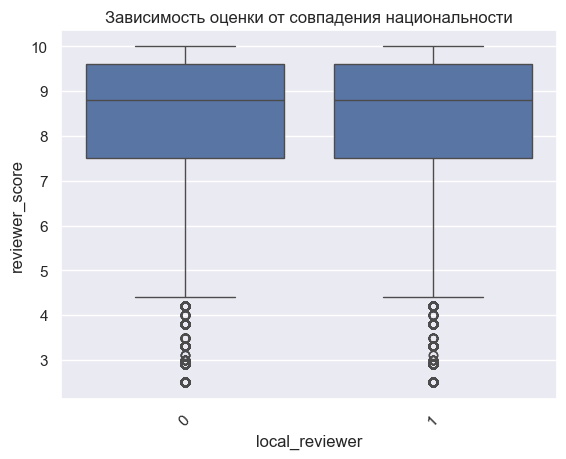

In [63]:

data[data['sample']==1]
sns.boxplot(y = 'reviewer_score', x = 'local_reviewer', data=data).set(title = 'Зависимость оценки от совпадения национальности')
plt.ylabel = 'Национальность совпадает'
plt.xlabel = 'Выставленный рейтинг'
plt.xticks(rotation=45)

Визуально оценка отеля мало зависит от того, совпадает национальность гостя со страной отеля или нет.

Проверим статистически при помощи критерия хи-квадрат.

Нулевая гипотеза: взаимосвязи между признаками нет.

Альтернативная гипотеза: взаимосвязь между признаками есть.



In [64]:
chi_2(data, 'local_reviewer')

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Зависимость есть. Оставляем признак



## Проверим, а есть ли вообще зависимость оценки от национальности гостя


In [65]:
# Посмотрим, сколько всего национальностей у гостей
data['reviewer_nationality'].nunique()

225

Слишком много. Уменьшим до 10



In [66]:
def reduce_categories_number(df, col, n, name):
    popular_values = df[col].value_counts().nlargest(n).index
    df[col] = df[col].apply(lambda x: x if x in popular_values else name)
    return df

In [67]:

data = reduce_categories_number(data, 'reviewer_nationality', 10, 'Other_nat')
data.head()

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,days_since_review,lat,lng,sample,reviewer_score,country,Spain_Austria,review_day_of_week,is_Jan_or_Feb,local_reviewer
128935,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,531 day,51.507894,-0.143671,1,10.0,United Kingdom,0,4,1,1
128936,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,203 day,51.521009,-0.123097,1,6.3,United Kingdom,0,3,1,1
128937,32,8.9,Legend Saint Germain by Elegancia,Other_nat,No kettle in room,6,406,No Positive,0,14,...,289 day,48.845377,2.325643,1,7.5,France,0,1,0,0
128938,34,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,...,681 day,48.888697,2.394540,1,10.0,France,0,1,0,0
128939,914,8.5,Golden Tulip Amsterdam West,Other_nat,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,...,516 day,52.385601,4.847060,1,9.6,Netherlands,0,5,0,0


Посмотрим на распределение оценок по выделенным категориям

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ' United Kingdom '),
  Text(1, 0, 'Other_nat'),
  Text(2, 0, ' Switzerland '),
  Text(3, 0, ' United Arab Emirates '),
  Text(4, 0, ' United States of America '),
  Text(5, 0, ' Netherlands '),
  Text(6, 0, ' Ireland '),
  Text(7, 0, ' Canada '),
  Text(8, 0, ' Germany '),
  Text(9, 0, ' Australia '),
  Text(10, 0, ' Saudi Arabia ')])

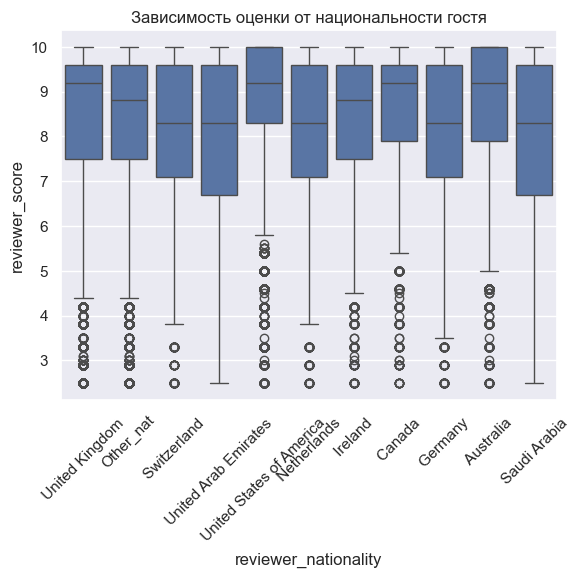

In [68]:

data[data['sample']==1]
sns.boxplot(y = 'reviewer_score', x = 'reviewer_nationality', data=data).set(title = 'Зависимость оценки от национальности гостя')
plt.ylabel = 'Национальность'
plt.xlabel = 'Выставленный рейтинг'
plt.xticks(rotation=45)

Судя по графику, национальность ревьюера оказывает влияние на выставленную оценку. Проверим эту гипотезу статистически.

Поскольку у нас два категориальных признака - национальность ревьюера и его оценка - и поскольку в каждом из признаков больше 5 категорий, можно воспользоваться критерием хи-квадрат.

Нулевая гипотеза: признаки независимы

Альтернативная гипотеза: признаки зависимы

In [69]:
chi_2(data, 'reviewer_nationality')

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


И статистический анализ, и визуальный говорит, что национальность ревьюера имеет значение. Оставляем признак.

## 4. Изучим признак тэгов.

In [70]:
# Подсчитаем частотность значений в колонке tags
# для этого сначала составим словарь из всех возможных значений поля tags, а затем подсчитаем, сколько этих значений максимально в одной ячейке

tags_collection = []
tags_count = {}
tags_figure = 0
def clean_tags(tags):
    tags = tags.replace('[', '')
    tags = tags.replace(']', '')
    tags = tags.replace("'", '')
    return tags.split(',')

def count_tags(tags, tags_figure):
    # очищаем поле tags от "мусора"
    tags_list = clean_tags(tags)
    f = len(tags_list)
    # Добавляем элемент в список, если его там еще нет
    for el in tags_list:
        if el.strip() in tags_collection:
            tags_count[el.strip()] += 1
        else:
            tags_collection.append(el.strip())
            tags_count[el.strip()] = 1
    # Определяем максимальный размер списка тэгов в одной ячейке
    if f > tags_figure:
        return f
    else:
        return tags_figure       
  
# Считаем максимальное количество тэгов в одной ячейке и заодно заполняем список уникальных тэгов
tags_figure = data['tags'].apply(lambda x: count_tags(x, tags_figure))

print(f'Max tags count for 1 cell = {tags_figure.max()}')
print(f'Count of unique tags = {len(tags_collection)}')
tags_count = {k: v for k, v in sorted(tags_count.items(), key = lambda item: item[1], reverse = True)}

Max tags count for 1 cell = 6
Count of unique tags = 2368


## 4.1 Оценим влияние типа поездки


In [71]:
## Выделим тип поездки из поля тэгов 

def extract_trip(tags):
    tags_list = clean_tags(tags)
    for el in tags_list:
        if 'trip' in el:
            return el.strip()
    return 'Not a trip'

data['trip'] = data['tags'].apply(extract_trip)
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,lat,lng,sample,reviewer_score,country,Spain_Austria,review_day_of_week,is_Jan_or_Feb,local_reviewer,trip
128935,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,51.507894,-0.143671,1,10.0,United Kingdom,0,4,1,1,Leisure trip
128936,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,51.521009,-0.123097,1,6.3,United Kingdom,0,3,1,1,Business trip
128937,32,8.9,Legend Saint Germain by Elegancia,Other_nat,No kettle in room,6,406,No Positive,0,14,...,48.845377,2.325643,1,7.5,France,0,1,0,0,Leisure trip


([0, 1, 2],
 [Text(0, 0, 'Leisure trip'),
  Text(1, 0, 'Business trip'),
  Text(2, 0, 'Not a trip')])

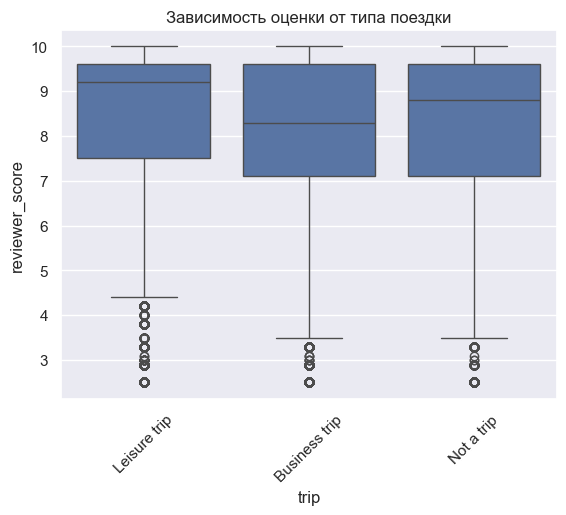

In [72]:
data[data['sample']==1]
sns.boxplot(y = 'reviewer_score', x = 'trip', data=data).set(title = 'Зависимость оценки от типа поездки')
plt.ylabel = 'Тип поездки'
plt.xlabel = 'Выставленный рейтинг'
plt.xticks(rotation=45)

Видно, что есть зависимость выставленной оценки от типа поездки. Проверим статистически.

In [73]:
chi_2(data, 'trip')


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Тип поездки оказывает влияние на выставленную оценку. Оставляем признак.



## 4.2 Оценим влияние на оценку количества ночей, которые гость провел в отеле


In [74]:
# Выделим из признака тэгов количество ночей, которые гость оставался в отеле.

def extract_nights(tags):
    tags_list = clean_tags(tags)
    for el in tags_list:
        if 'Stayed' in el:
            result = re.findall(r'\d+', el)
            return str(result[0]) + 'nights'
    return 0

data['nights'] = data['tags'].apply(extract_nights)
data['nights'].value_counts()

nights
1nights     145373
2nights     100263
3nights      72000
4nights      35748
5nights      15611
6nights       7399
7nights       5549
8nights       1910
9nights        966
10nights       663
11nights       306
12nights       217
14nights       184
13nights       174
0              146
15nights        87
16nights        38
17nights        27
18nights        24
19nights        23
21nights        19
20nights        17
27nights        10
30nights        10
22nights         8
28nights         7
26nights         6
23nights         6
24nights         5
25nights         4
29nights         3
Name: count, dtype: int64

In [75]:
# Уменьшим количество ночей
data = reduce_categories_number(data, 'nights', 10, 'Other_night')
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,lng,sample,reviewer_score,country,Spain_Austria,review_day_of_week,is_Jan_or_Feb,local_reviewer,trip,nights
128935,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,-0.143671,1,10.0,United Kingdom,0,4,1,1,Leisure trip,2nights
128936,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,-0.123097,1,6.3,United Kingdom,0,3,1,1,Business trip,1nights
128937,32,8.9,Legend Saint Germain by Elegancia,Other_nat,No kettle in room,6,406,No Positive,0,14,...,2.325643,1,7.5,France,0,1,0,0,Leisure trip,3nights


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, '2nights'),
  Text(1, 0, '1nights'),
  Text(2, 0, '3nights'),
  Text(3, 0, '6nights'),
  Text(4, 0, '4nights'),
  Text(5, 0, '5nights'),
  Text(6, 0, '8nights'),
  Text(7, 0, '7nights'),
  Text(8, 0, '10nights'),
  Text(9, 0, 'Other_night'),
  Text(10, 0, '9nights')])

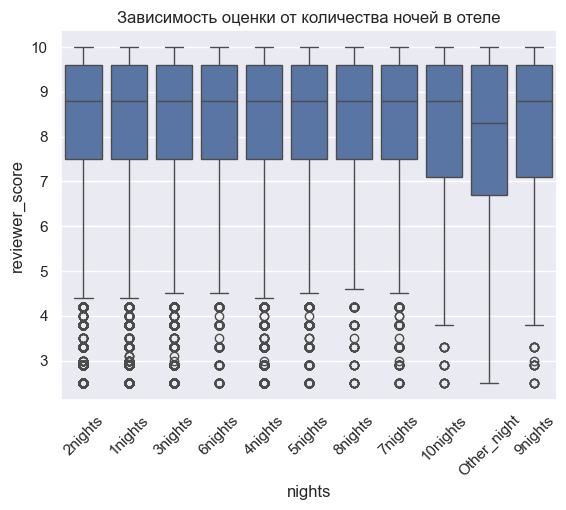

In [76]:
data[data['sample']==1]
sns.boxplot(y = 'reviewer_score', x = 'nights', data=data).set(title = 'Зависимость оценки от количества ночей в отеле')
plt.ylabel = 'Количество ночей'
plt.xlabel = 'Выставленный рейтинг'
plt.xticks(rotation=45)

Визуально различий между категориями признака почти нет. Проверим статистически.

Нулевая гипотеза Оценка отеля не зависит от того, сколько ночей клиент провел в отеле

Альтернативная гипотеза Признаки зависимы

In [77]:
chi_2(data, 'nights')

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Оставляем признак



## 4.3. Изучим влияние типа номера на оценку

In [78]:
def extract_room(tags):
    tags_list = clean_tags(tags)
    for el in tags_list:
        if 'Room' in el:
            return el.strip()
    return 'Unknown'

data['rooms'] = data['tags'].apply(extract_room)

data = reduce_categories_number(data, 'rooms', 10, 'Other_room')
data['rooms'].value_counts()

rooms
Other_room                      198001
Unknown                          35927
Double Room                      26386
Standard Double Room             24151
Superior Double Room             23550
Deluxe Double Room               18623
Double or Twin Room              16824
Standard Double or Twin Room     13062
Classic Double Room              12716
Superior Double or Twin Room     10238
Standard Twin Room                7325
Name: count, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Unknown'),
  Text(1, 0, 'Standard Double Room'),
  Text(2, 0, 'Other_room'),
  Text(3, 0, 'Standard Double or Twin Room'),
  Text(4, 0, 'Superior Double Room'),
  Text(5, 0, 'Double Room'),
  Text(6, 0, 'Double or Twin Room'),
  Text(7, 0, 'Classic Double Room'),
  Text(8, 0, 'Standard Twin Room'),
  Text(9, 0, 'Deluxe Double Room'),
  Text(10, 0, 'Superior Double or Twin Room')])

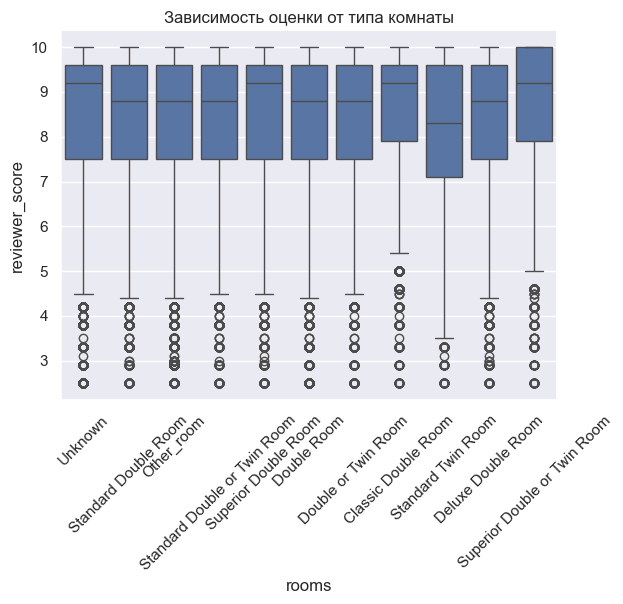

In [79]:
data[data['sample']==1]
sns.boxplot(y = 'reviewer_score', x = 'rooms', data=data).set(title = 'Зависимость оценки от типа комнаты')
plt.ylabel = 'Тип комнаты'
plt.xlabel = 'Выставленный рейтинг'
plt.xticks(rotation=45)

Видно, что оценка довольно сильно зависит от того, в какой комнате жил гость. Проверим статистически.

Нулевая гипотеза Оценка отеля не зависит от того, в какой комнате жил гость

Альтернативная гипотеза Признаки зависимы

In [80]:
chi_2(data, 'rooms')


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.



Выставленная оценка зависит от типа комнаты, в которой жил ревьюер



## 4.4 Изучим влияние количества выставленных тэгов на оценку

In [81]:
def tag_count(tags):
    tags_list = clean_tags(tags)
    return str(len(tags_list)) + ' tags'

data['tags_count'] = data['tags'].apply(tag_count)
data['tags_count'].head(10)


128935    5 tags
128936    4 tags
128937    5 tags
128938    4 tags
128939    4 tags
128940    5 tags
128941    5 tags
128942    4 tags
128943    4 tags
128944    5 tags
Name: tags_count, dtype: object

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, '5 tags'),
  Text(1, 0, '4 tags'),
  Text(2, 0, '3 tags'),
  Text(3, 0, '6 tags'),
  Text(4, 0, '2 tags'),
  Text(5, 0, '1 tags')])

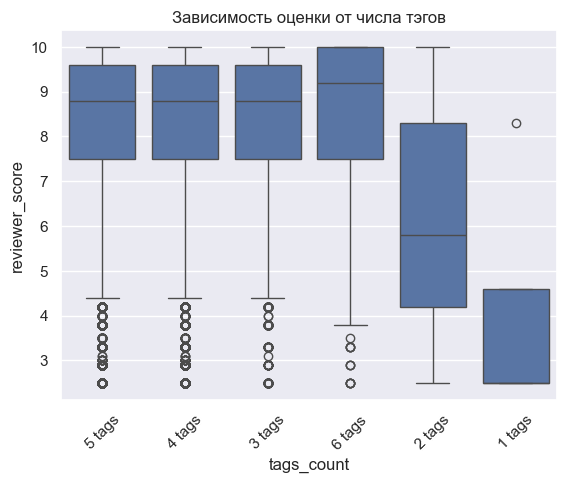

In [82]:
sns.boxplot(y = 'reviewer_score', x = 'tags_count', data=data).set(title = 'Зависимость оценки от числа тэгов')
plt.ylabel = 'Число тэгов'
plt.xlabel = 'Выставленный рейтинг'
plt.xticks(rotation=45)

Видно, что оценка, вероятно, зависит от того, сколько тэгов поставил гость. Проверим статистически.

Нулевая гипотеза Оценка отеля не зависит от того, сколько тэгов поставлено

Альтернативная гипотеза Признаки зависимы

In [83]:
chi_2(data, 'tags_count')


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Оставляем признак



## 5. Проанализируем текст оценки


In [84]:
# Начнем с позитивного текста оценки
data['positive_review'].value_counts().head(25)

positive_review
No Positive            26885
 Location               6833
 Everything             1697
 location               1251
 Nothing                 931
 The location            830
 Great location          809
 Good location           690
 Location                663
 Breakfast               455
 Everything              449
 Friendly staff          385
 Staff                   347
 Excellent location      296
 Great location          280
 Location and staff      256
 everything              233
 Good location           214
 Nothing                 170
 nothing                 159
 Comfy bed               158
 The location            152
 good location           151
 The staff               151
 the location            141
Name: count, dtype: int64

In [85]:
#Проверим, содержит ли позитивный текст оценки что-то вроде No positive или nothing
def extract_positive(review):
    if 'no positive' in review.lower() or 'nothing' in review.lower():
        return 0
    return 1

#введем новый признак, есть ли позитивный текст у оценки
data['is_positive'] = data['positive_review'].apply(extract_positive)
data['is_positive'].value_counts()

is_positive
1    354956
0     31847
Name: count, dtype: int64

In [86]:
# теперь проверим негативный отзыв точно так же
data['negative_review'].value_counts().head(25)

negative_review
No Negative            95907
 Nothing               10737
 Nothing                3154
 nothing                1660
 N A                     802
 None                    737
                         606
 N a                     384
 Breakfast               296
 Small room              283
 Location                281
 All good                251
 Everything              251
 Nothing really          240
 none                    223
 nothing                 219
 No complaints           201
 Nil                     197
 Nothing really          195
 Price                   192
 n a                     176
 Nothing to dislike      159
 Nothing at all          154
 Nothing at all          139
 Small rooms             135
Name: count, dtype: int64

In [87]:
# Проверим, содержит ли текст негативной оценки слова, отрицающие негативную оценку
def extract_negative(review):
    if 'no negative' in review.lower() or 'nothing' in review.lower() or 'n a' in review.lower() or 'none' in review.lower():
        return 0
    if 'nil' in review.lower() or 'no complaints' in review.lower() or 'all good' in review.lower():
        return 0
    return 1

# Заведем новый признак, есть ли негатив в негативном отзыве
data['is_negative'] = data['negative_review'].apply(extract_negative)
data['is_negative'].value_counts()

is_negative
1    218615
0    168188
Name: count, dtype: int64

In [88]:
# Загрузим корпус данных для анализа тональности:

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

# Используем метод polarity_scores для анализа тональности негативных и позитивных отзывов. 
# Результаты запишем в столбцы neg_sent и pos_sent. Также, для того, чтобы эту информацию можно 
# было использовать в обучении модели, создадим отдельные признаки со значениями neg, neu, pos 
# и compound, которые определяют степень отрицательности, нейтральности, положительности и 
# общую тональность текста соответственно:

data['neg_sent'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

data['neg_sent_neg'] = data['neg_sent'].apply(lambda x: x['neg'])
data['neg_sent_neu'] = data['neg_sent'].apply(lambda x: x['neu'])
data['neg_sent_pos'] = data['neg_sent'].apply(lambda x: x['pos'])
data['neg_sent_cmpnd'] = data['neg_sent'].apply(lambda x: x['compound'])

data['pos_sent'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

data['pos_sent_neg'] = data['pos_sent'].apply(lambda x: x['neg'])
data['pos_sent_neu'] = data['pos_sent'].apply(lambda x: x['neu'])
data['pos_sent_pos'] = data['pos_sent'].apply(lambda x: x['pos'])
data['pos_sent_cmpnd'] = data['pos_sent'].apply(lambda x: x['compound'])
data.info()

[nltk_data] Error loading vader_lexicon: <urlopen error [WinError
[nltk_data]     10060] Попытка установить соединение была безуспешной,
[nltk_data]     т.к. от другого компьютера за требуемое время не
[nltk_data]     получен нужный отклик, или было разорвано уже
[nltk_data]     установленное соединение из-за неверного отклика уже
[nltk_data]     подключенного компьютера>


<class 'pandas.core.frame.DataFrame'>
Index: 386803 entries, 128935 to 515737
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   hotel_name                                  386803 non-null  object 
 3   reviewer_nationality                        386803 non-null  object 
 4   negative_review                             386803 non-null  object 
 5   review_total_negative_word_counts           386803 non-null  int64  
 6   total_number_of_reviews                     386803 non-null  int64  
 7   positive_review                             386803 non-null  object 
 8   review_total_positive_word_counts           386803 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 

In [89]:
# Удалим лишние признаки
data = data.drop(['neg_sent', 'pos_sent'], axis = 1)

## 6. Числовые признаки

In [90]:
#Извлекаем числовой признак из колонки days_since_review
data['days_since_review'] = data['days_since_review'].apply(lambda x: int((str(x).replace(' day', '')).replace('s', '')))
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,is_positive,is_negative,neg_sent_neg,neg_sent_neu,neg_sent_pos,neg_sent_cmpnd,pos_sent_neg,pos_sent_neu,pos_sent_pos,pos_sent_cmpnd
128935,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,1,1,0.000,1.000,0.0,0.0000,0.000,0.345,0.655,0.5859
128936,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,1,1,0.756,0.244,0.0,-0.4767,0.000,1.000,0.000,0.0000
128937,32,8.9,Legend Saint Germain by Elegancia,Other_nat,No kettle in room,6,406,No Positive,0,14,...,0,1,0.423,0.577,0.0,-0.2960,0.379,0.000,0.621,0.3400


Видим, что колонки total_number_of_reviews и additional_number_of_scoring имеют значение в сотни и даже тысячи, в то время как колонки, полученные только что при оценке степени положительности и отрицательности отзыва, варьируются от 0 до 1.

Нормализуем колонки

In [91]:
# Сначала преобразуем колонку additional_number_of_scoring
data['number_scoring_normal'] = (data['additional_number_of_scoring']-data['additional_number_of_scoring'].mean())/data['additional_number_of_scoring'].std()
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,is_negative,neg_sent_neg,neg_sent_neu,neg_sent_pos,neg_sent_cmpnd,pos_sent_neg,pos_sent_neu,pos_sent_pos,pos_sent_cmpnd,number_scoring_normal
128935,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,1,0.000,1.000,0.0,0.0000,0.000,0.345,0.655,0.5859,0.165422
128936,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,1,0.756,0.244,0.0,-0.4767,0.000,1.000,0.000,0.0000,-0.398288
128937,32,8.9,Legend Saint Germain by Elegancia,Other_nat,No kettle in room,6,406,No Positive,0,14,...,1,0.423,0.577,0.0,-0.2960,0.379,0.000,0.621,0.3400,-0.932012


In [92]:
# Потом колонку total_number_of_reviews
data['total_number_normal'] = (data['total_number_of_reviews']-data['total_number_of_reviews'].mean())/data['total_number_of_reviews'].std()
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,neg_sent_neg,neg_sent_neu,neg_sent_pos,neg_sent_cmpnd,pos_sent_neg,pos_sent_neu,pos_sent_pos,pos_sent_cmpnd,number_scoring_normal,total_number_normal
128935,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,0.000,1.000,0.0,0.0000,0.000,0.345,0.655,0.5859,0.165422,-0.323767
128936,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,0.756,0.244,0.0,-0.4767,0.000,1.000,0.000,0.0000,-0.398288,-0.597029
128937,32,8.9,Legend Saint Germain by Elegancia,Other_nat,No kettle in room,6,406,No Positive,0,14,...,0.423,0.577,0.0,-0.2960,0.379,0.000,0.621,0.3400,-0.932012,-1.009297


In [93]:
#Потом колонку total_number_of_reviews_reviewer_has_given
data['total_rev_number_normal'] = (data['total_number_of_reviews_reviewer_has_given']-data['total_number_of_reviews_reviewer_has_given'].mean())/data['total_number_of_reviews_reviewer_has_given'].std()
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,neg_sent_neu,neg_sent_pos,neg_sent_cmpnd,pos_sent_neg,pos_sent_neu,pos_sent_pos,pos_sent_cmpnd,number_scoring_normal,total_number_normal,total_rev_number_normal
128935,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,1.000,0.0,0.0000,0.000,0.345,0.655,0.5859,0.165422,-0.323767,-0.016034
128936,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,0.244,0.0,-0.4767,0.000,1.000,0.000,0.0000,-0.398288,-0.597029,0.617197
128937,32,8.9,Legend Saint Germain by Elegancia,Other_nat,No kettle in room,6,406,No Positive,0,14,...,0.577,0.0,-0.2960,0.379,0.000,0.621,0.3400,-0.932012,-1.009297,0.617197


In [94]:
#Удалим ненужные колонки 
data = data.drop(['additional_number_of_scoring', 'total_number_of_reviews', 'hotel_name', 'negative_review', 
                  'positive_review', 'total_number_of_reviews_reviewer_has_given'], axis = 1)
data.head(3)

,average_score,reviewer_nationality,review_total_negative_word_counts,review_total_positive_word_counts,tags,days_since_review,lat,lng,sample,reviewer_score,...,neg_sent_neu,neg_sent_pos,neg_sent_cmpnd,pos_sent_neg,pos_sent_neu,pos_sent_pos,pos_sent_cmpnd,number_scoring_normal,total_number_normal,total_rev_number_normal
128935,8.4,United Kingdom,3,4,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531,51.507894,-0.143671,1,10.0,...,1.000,0.0,0.0000,0.000,0.345,0.655,0.5859,0.165422,-0.323767,-0.016034
128936,8.3,United Kingdom,3,2,"[' Business trip ', ' Couple ', ' Standard Dou...",203,51.521009,-0.123097,1,6.3,...,0.244,0.0,-0.4767,0.000,1.000,0.000,0.0000,-0.398288,-0.597029,0.617197
128937,8.9,Other_nat,6,0,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289,48.845377,2.325643,1,7.5,...,0.577,0.0,-0.2960,0.379,0.000,0.621,0.3400,-0.932012,-1.009297,0.617197


In [95]:
#Осталась ненормализованной колонка days_since_review. Нормализуем ее
data['days_normal'] = (data['days_since_review']-data['days_since_review'].mean())/data['days_since_review'].std()
data.head(3)

,average_score,reviewer_nationality,review_total_negative_word_counts,review_total_positive_word_counts,tags,days_since_review,lat,lng,sample,reviewer_score,...,neg_sent_pos,neg_sent_cmpnd,pos_sent_neg,pos_sent_neu,pos_sent_pos,pos_sent_cmpnd,number_scoring_normal,total_number_normal,total_rev_number_normal,days_normal
128935,8.4,United Kingdom,3,4,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531,51.507894,-0.143671,1,10.0,...,0.0,0.0000,0.000,0.345,0.655,0.5859,0.165422,-0.323767,-0.016034,0.845134
128936,8.3,United Kingdom,3,2,"[' Business trip ', ' Couple ', ' Standard Dou...",203,51.521009,-0.123097,1,6.3,...,0.0,-0.4767,0.000,1.000,0.000,0.0000,-0.398288,-0.597029,0.617197,-0.724430
128937,8.9,Other_nat,6,0,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289,48.845377,2.325643,1,7.5,...,0.0,-0.2960,0.379,0.000,0.621,0.3400,-0.932012,-1.009297,0.617197,-0.312898


## 7. Перекодировка категориальных признаков


In [96]:
# Вспомогательная функция, очищающая поле tags от лишних символов
def clean_tags(tags):
    tags = tags.replace('[', '')
    tags = tags.replace(']', '')
    tags = tags.replace("'", '')
    return tags.split(',')
## функция кодирует методом OHE переданную в нее колонку и возвращает новый датасет
def one_hot_manual(df, column, drop_last: True):
  
    for_modify = pd.get_dummies(df[column])
    to_drop = ''
    for col in for_modify.columns:
        for_modify[col] = for_modify[col].apply(lambda x: 1 if x else 0)
        to_drop = col
    if drop_last:
        for_modify = for_modify.drop(to_drop, axis = 1)
    df = pd.concat([df, for_modify], axis = 1, join = 'inner')
    df = df.drop(column, axis = 1)
    return df

In [97]:
# Перекодируем категориальные признаки при помощи вспомогательной функции

df = one_hot_manual(data, 'trip', False)
df = one_hot_manual(df, 'tags_count', False)
df = one_hot_manual(df, 'reviewer_nationality', True)
df = one_hot_manual(df, 'review_day_of_week', True)
df = one_hot_manual(df, 'nights', True)
df = one_hot_manual(df, 'rooms', True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386803 entries, 128935 to 515737
Data columns (total 72 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   average_score                      386803 non-null  float64
 1   review_total_negative_word_counts  386803 non-null  int64  
 2   review_total_positive_word_counts  386803 non-null  int64  
 3   tags                               386803 non-null  object 
 4   days_since_review                  386803 non-null  int64  
 5   lat                                386803 non-null  float64
 6   lng                                386803 non-null  float64
 7   sample                             386803 non-null  int64  
 8   reviewer_score                     386803 non-null  float64
 9   country                            386803 non-null  object 
 10  Spain_Austria                      386803 non-null  int64  
 11  is_Jan_or_Feb                      3868

In [98]:
df = df.drop(['tags'], axis = 1)

In [99]:
# Переименуем колонки с днями недели, сейчас их тип int и модель такое название не поймет
df.rename(columns = {0:'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
                     4:'Friday', 5: 'Saturday', 6: 'Sunday'}, inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386803 entries, 128935 to 515737
Data columns (total 71 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   average_score                      386803 non-null  float64
 1   review_total_negative_word_counts  386803 non-null  int64  
 2   review_total_positive_word_counts  386803 non-null  int64  
 3   days_since_review                  386803 non-null  int64  
 4   lat                                386803 non-null  float64
 5   lng                                386803 non-null  float64
 6   sample                             386803 non-null  int64  
 7   reviewer_score                     386803 non-null  float64
 8   country                            386803 non-null  object 
 9   Spain_Austria                      386803 non-null  int64  
 10  is_Jan_or_Feb                      386803 non-null  int64  
 11  local_reviewer                     3868

In [100]:
# Удалим лишние ячейки
df = df.drop(['country'], axis = 1)
df.head(3)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,days_since_review,lat,lng,sample,reviewer_score,Spain_Austria,is_Jan_or_Feb,...,Classic Double Room,Deluxe Double Room,Double Room,Double or Twin Room,Other_room,Standard Double Room,Standard Double or Twin Room,Standard Twin Room,Superior Double Room,Superior Double or Twin Room
128935,8.4,3,4,531,51.507894,-0.143671,1,10.0,0,1,...,0,0,0,0,0,0,0,0,0,0
128936,8.3,3,2,203,51.521009,-0.123097,1,6.3,0,1,...,0,0,0,0,0,1,0,0,0,0
128937,8.9,6,0,289,48.845377,2.325643,1,7.5,0,0,...,0,0,0,0,1,0,0,0,0,0


## 8. Проверка на мультиколлинеарность


In [101]:
# проверим корреляцию итоговых признаков
def chart_correlation_heatmap(df, 
                              columns, 
                              title, 
                              method='pearson', 
                              correlation_threshold=.6):
    """Построение корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(70, 70))
    correlation_matrix = df[columns].corr(method=method).abs()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix[correlation_matrix.abs() > correlation_threshold], 
                annot=True,
                annot_kws={"fontsize":16}, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='GnBu',
                fmt='.2f')
    ax_.set_title(title, fontsize=24)
    plt.show()

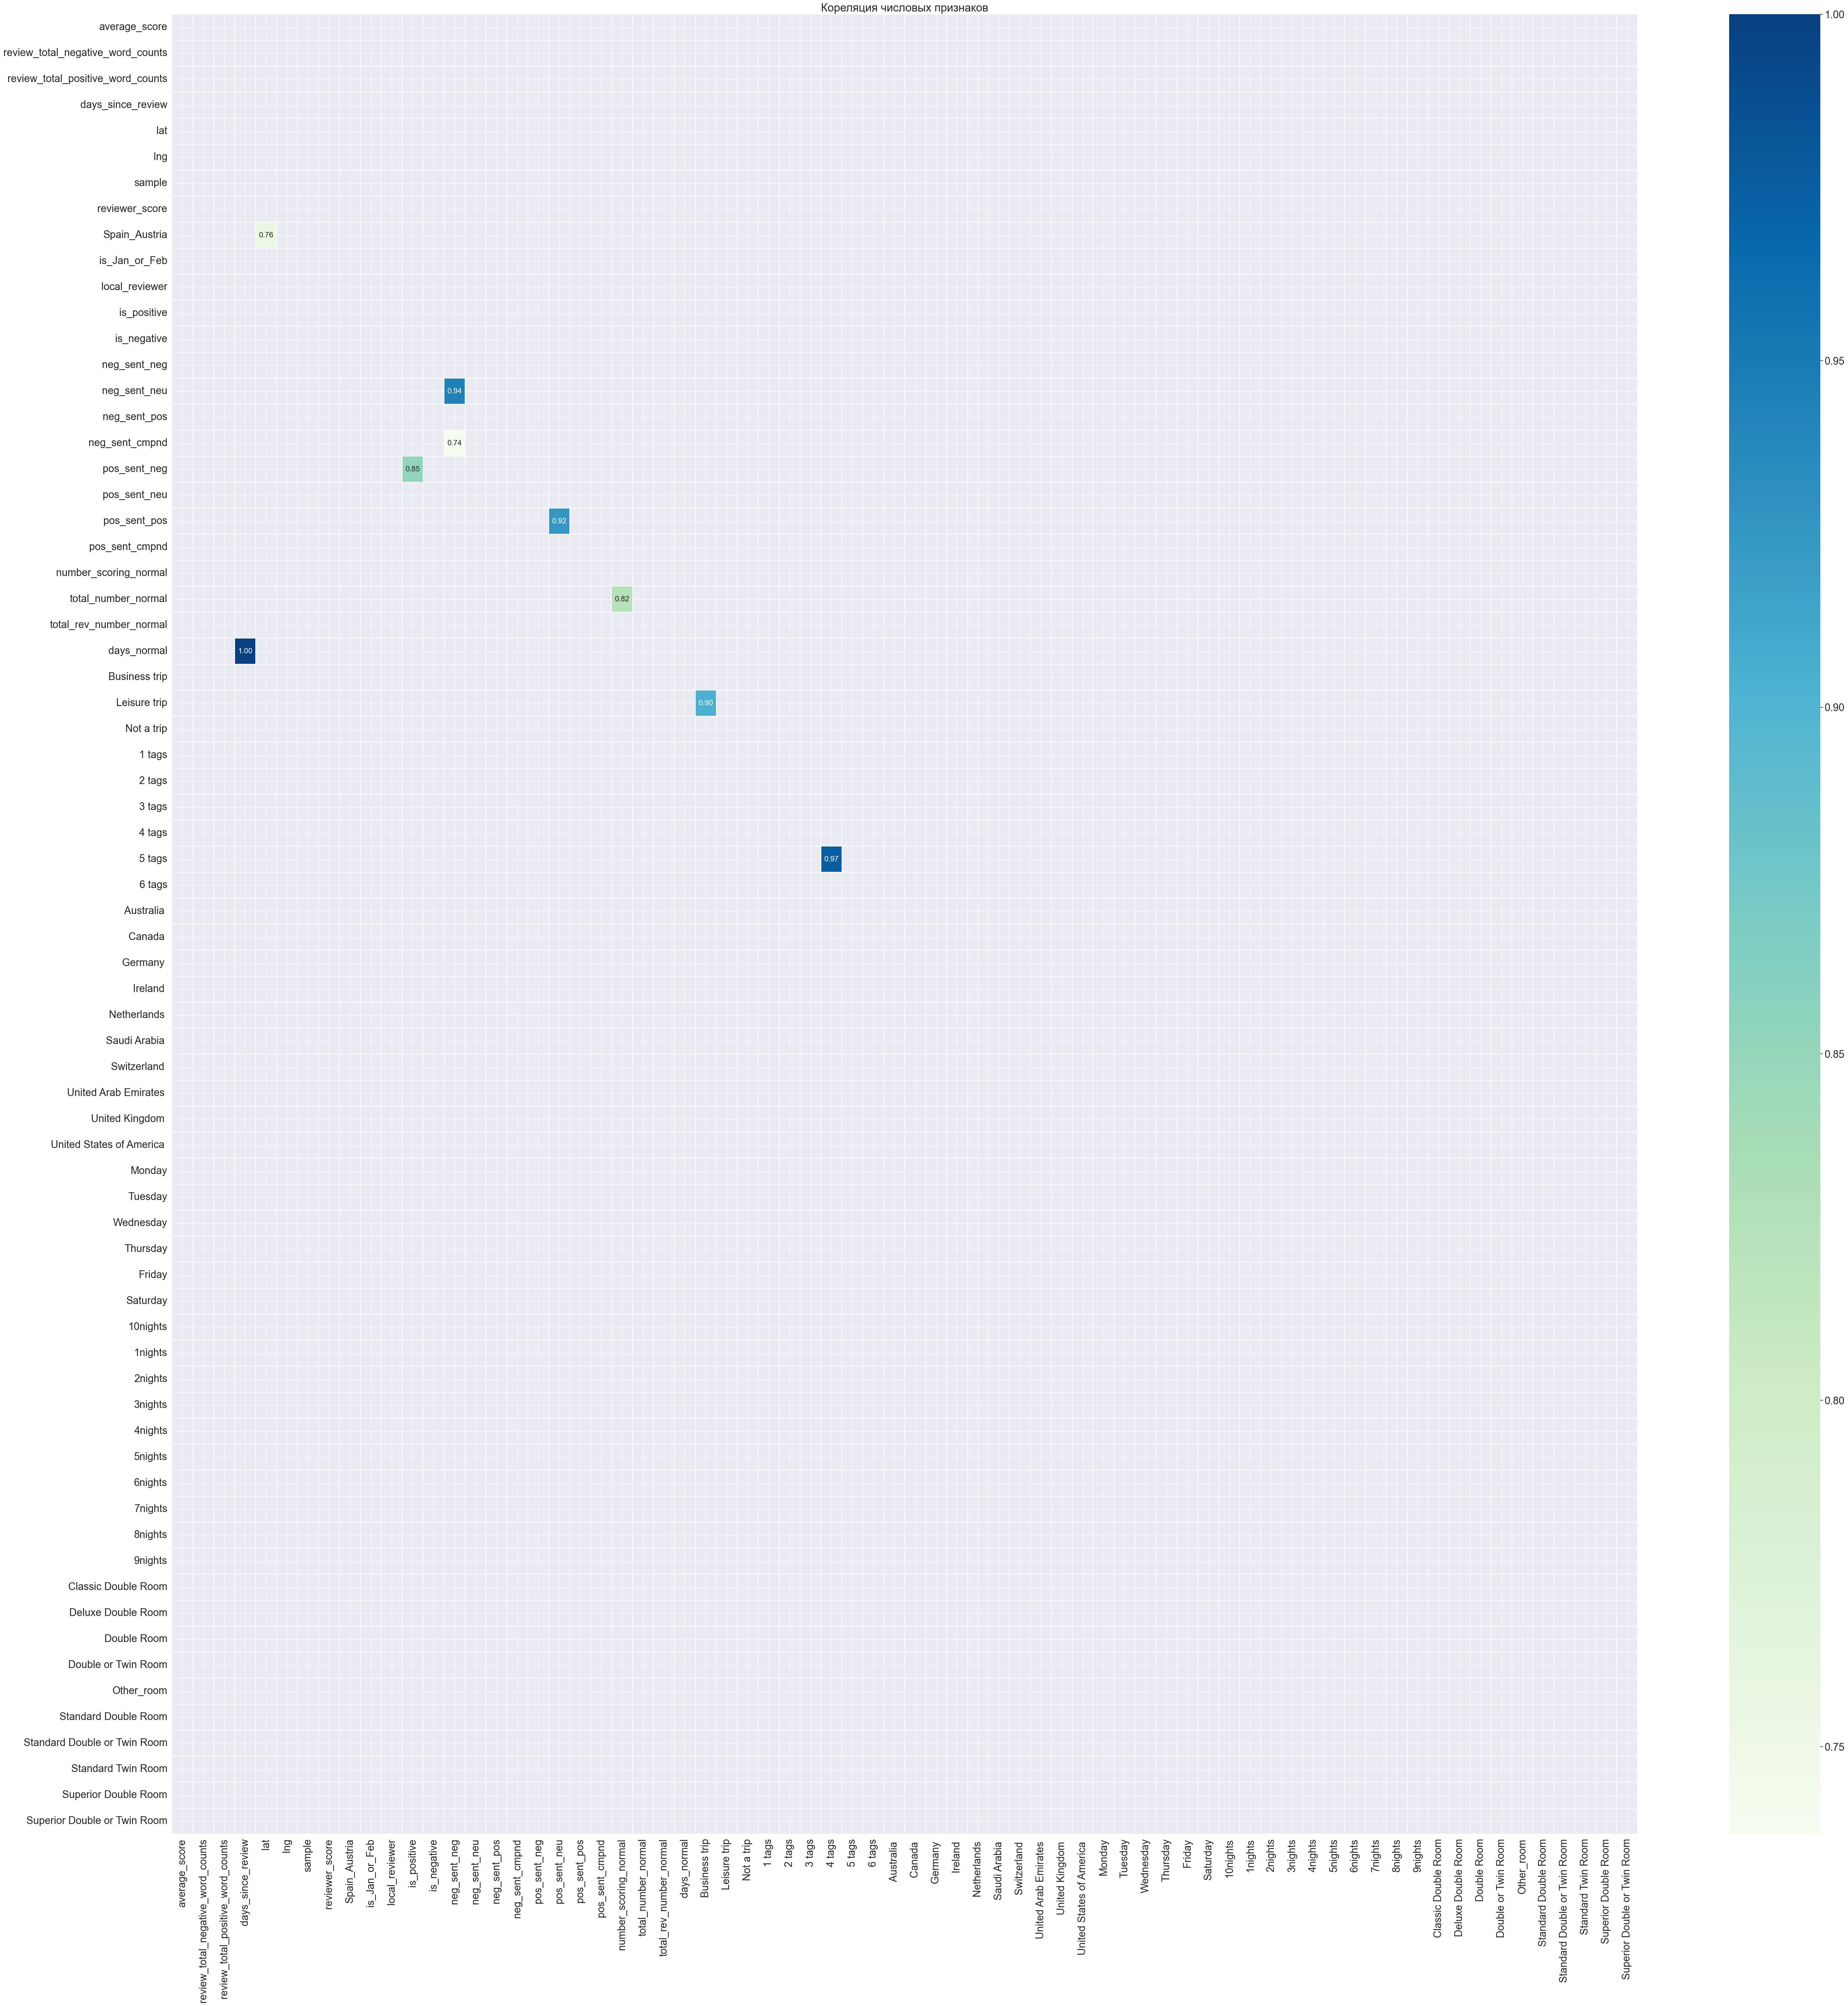

In [102]:
sns.set(font_scale=2)
chart_correlation_heatmap(df, 
                          df.columns, 
                          'Кореляция числовых признаков',
                          correlation_threshold = .7)

Видно, что корреляцией 0.7 или выше обладают следующие признаки:

Spain_Austria и lat

United Kingdom и local_reviewer

4 tags и from_mobile

5 tags и from_mobile

pos_sent_neg и is_positive

pos_sent_cmpnd и neg_sent_neg

neg_sent_neu и neg_sent_neg

pos_sent_pos и pos_sent_neu

total_number_normal и number_scoring_normal

Leisure trip и Business trip

5 tags и 4 tags

Проверим, какие из них оказывают большее влияние на признак оценки

In [103]:
# Проверим вклад колонок в итоговые признаки, чтобы определить, какие признаки больше влияют на результат
num_cols = ['total_number_normal', 'number_scoring_normal', 'pos_sent_neg', 'pos_sent_cmpnd', 
           'neg_sent_neg', 'pos_sent_pos', 'pos_sent_neu', 'neg_sent_neu']
cat_cols = ['Spain_Austria', 'lat', ' United Kingdom ', 'local_reviewer', '4 tags', '5 tags',
           'is_positive', 'Leisure trip', 'Business trip']

# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

<Axes: >

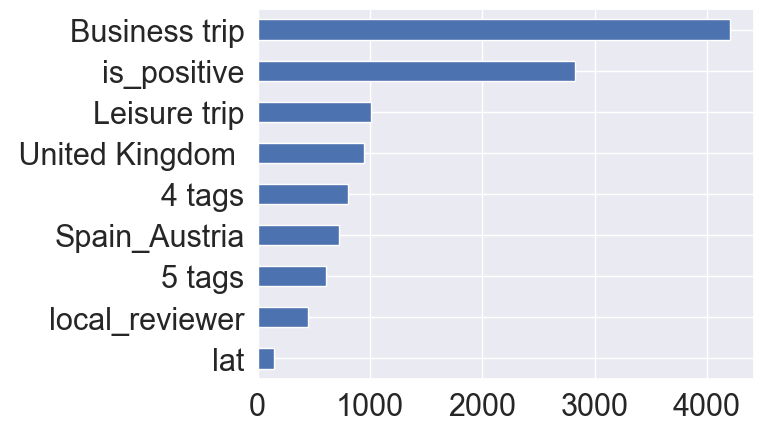

In [104]:
# Используем непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает 
# массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

y = y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<Axes: >

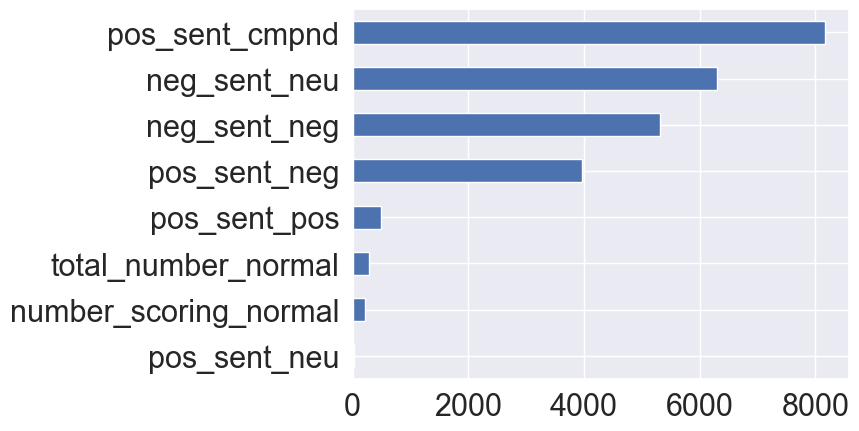

In [105]:
# Используем функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит анализ ANOVA. 
# Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

# Метод возвращает двумерный массив f-статистик и p-value для каждого признака. В качестве меры значимости используем значение 
# f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный 
# признак для нашей модели.

from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Удалим признаки pos_sent_neu, number_scoring_normal, is_positive, neg_sent_neg



In [106]:
df.drop(['pos_sent_neu', 'number_scoring_normal', 'is_positive', 'neg_sent_neg',
             'lat', '5 tags', 'local_reviewer', 'Leisure trip'], axis = 1, inplace=True)

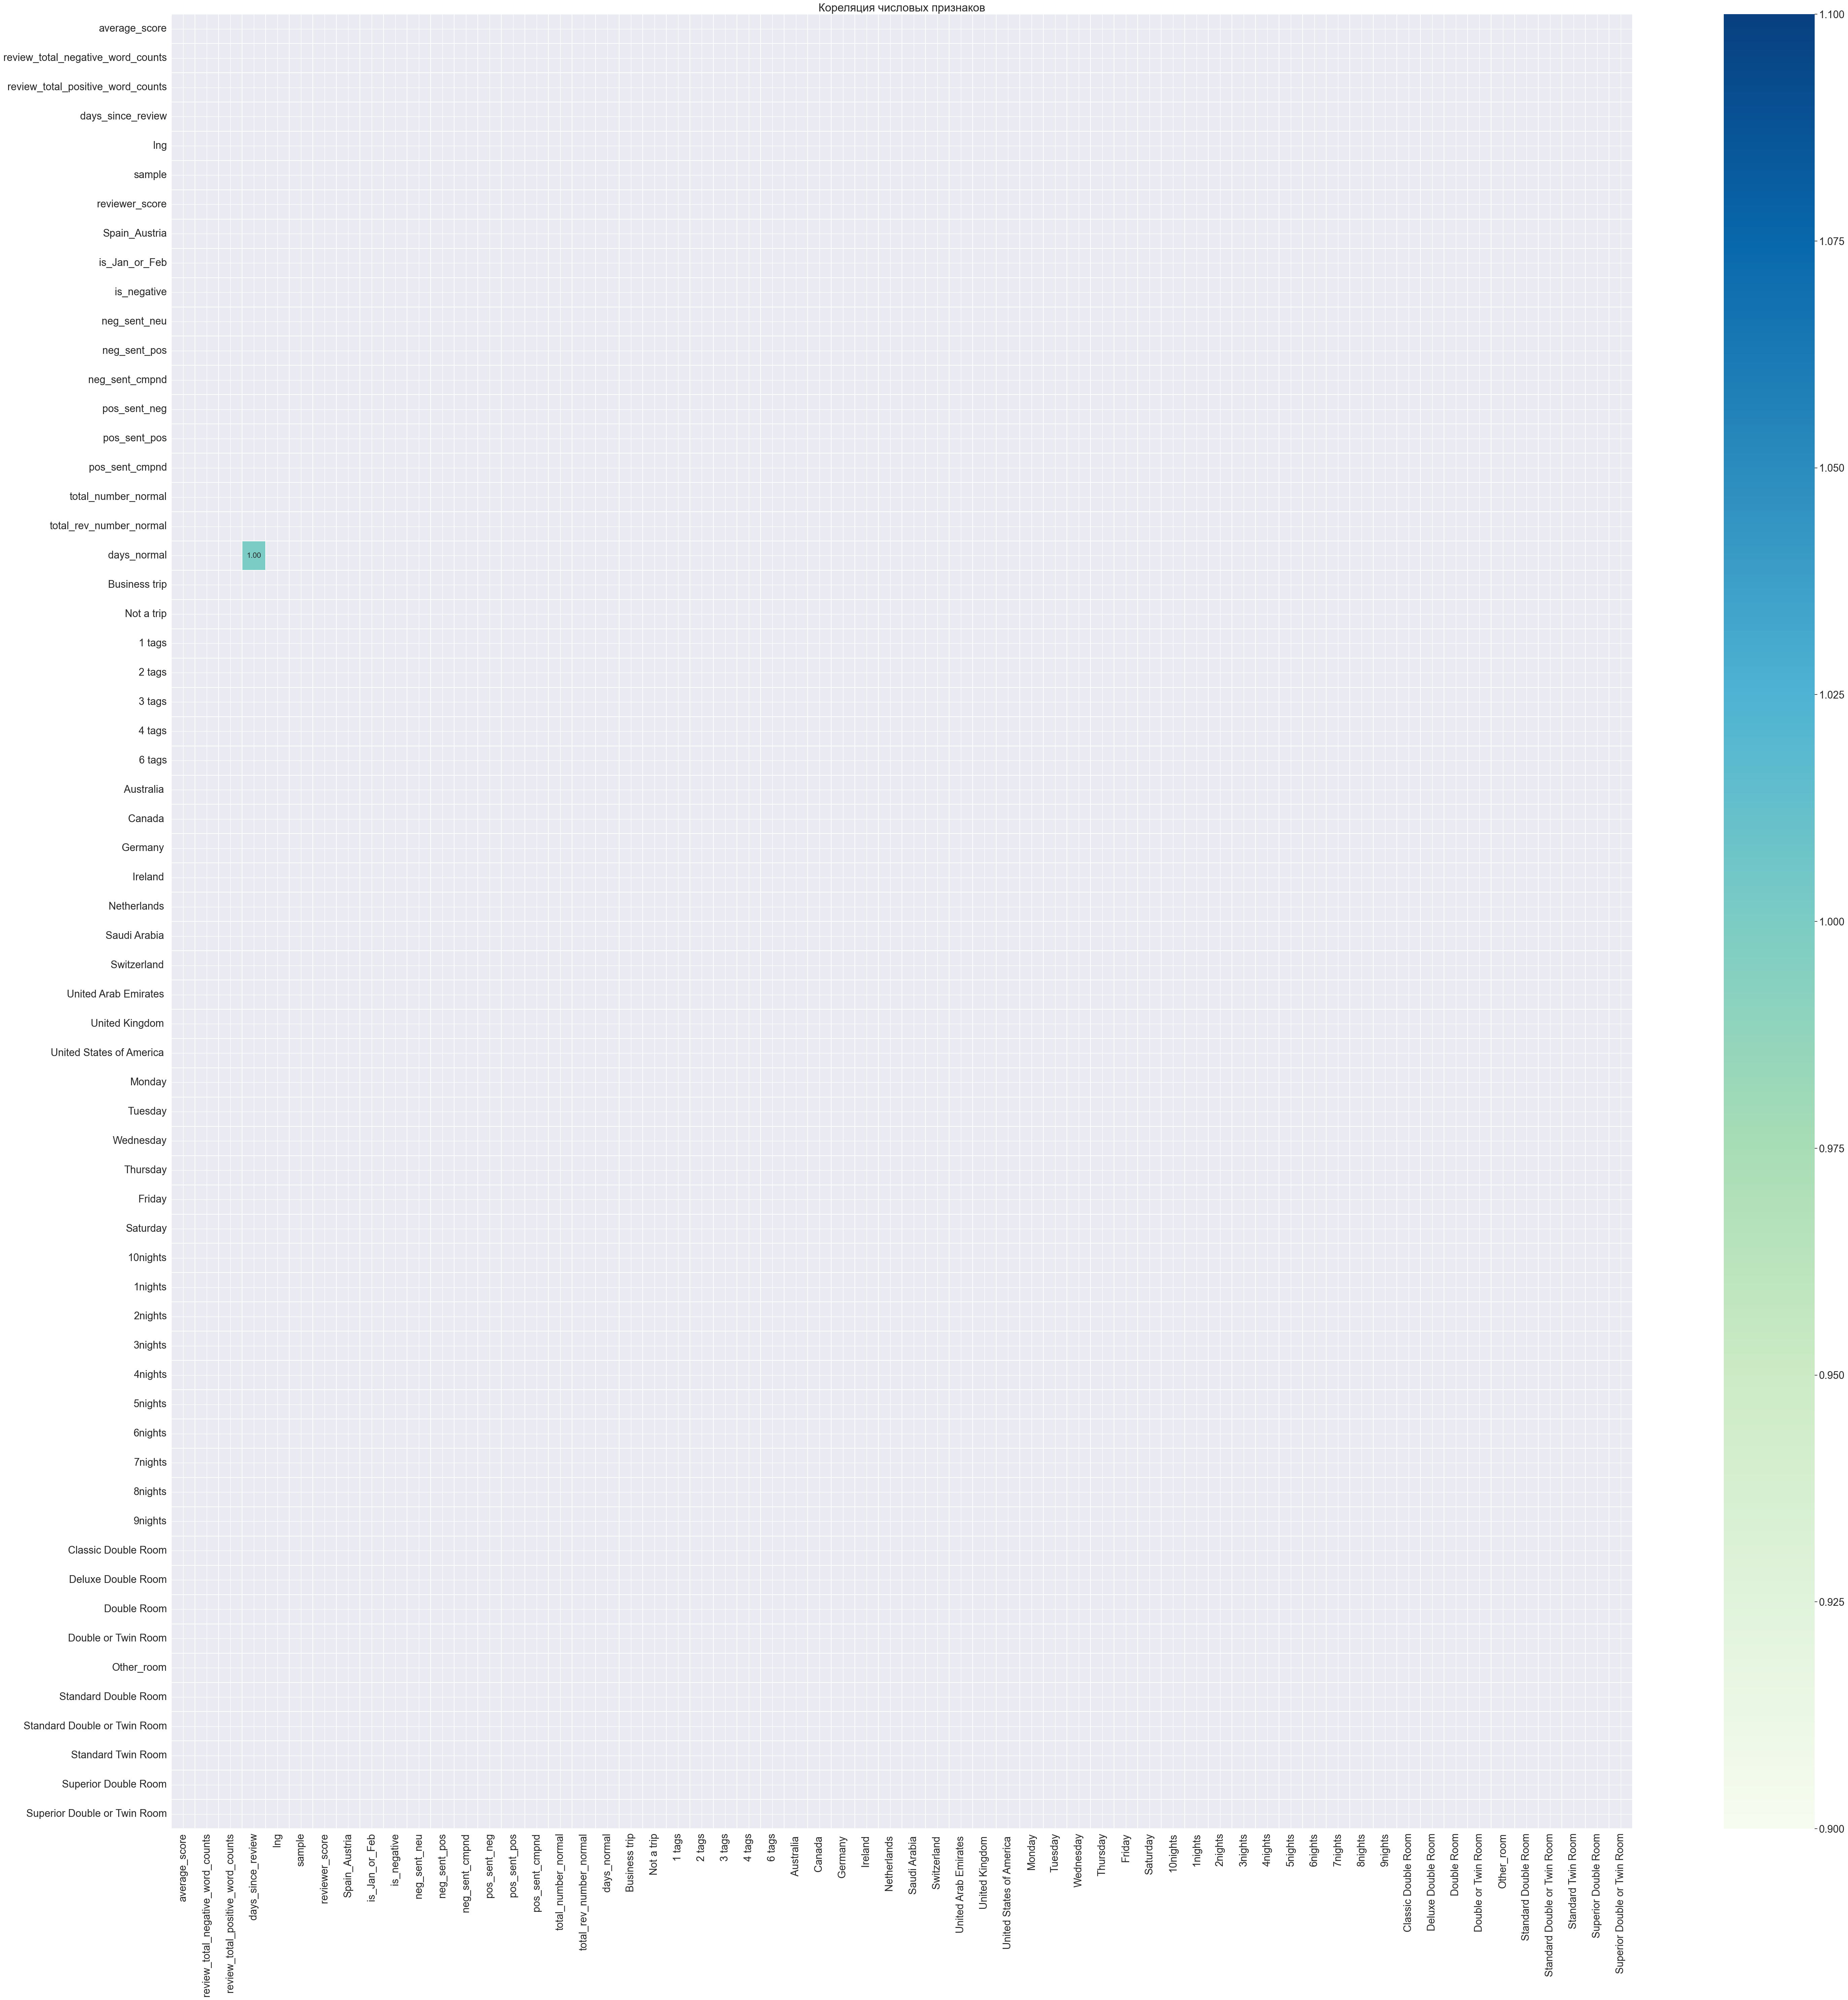

In [107]:
sns.set(font_scale=2)
chart_correlation_heatmap(df, 
                          df.columns, 
                          'Кореляция числовых признаков',
                          correlation_threshold = .7)

## 9. Построение модели

In [108]:
# Теперь выделим тестовую часть
test_data = df.query('sample == 1').drop(['sample'], axis=1)
train_data = df.query('sample == 0').drop(['sample'], axis=1)


y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)


In [109]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split 

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((0, 61), (386803, 61), (386803, 60), (309442, 60), (77361, 60))

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

model = RandomForestRegressor(
    n_estimators=100, 
    verbose=1, 
    n_jobs=-1, 
    random_state=RANDOM_SEED)

In [ ]:
# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.8s finished


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8675476402838637


In [ ]:
# оцениваем точность прогноза
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) # Этот коэффициент соответствует верхнему, если его вычесть из единицы.

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred)) 

MAPE: 0.12397899340754535


In [ ]:
metrics.mean_absolute_error(y_test, y_pred) + mean_absolute_percentage_error(y_test, y_pred)

0.991526633691409

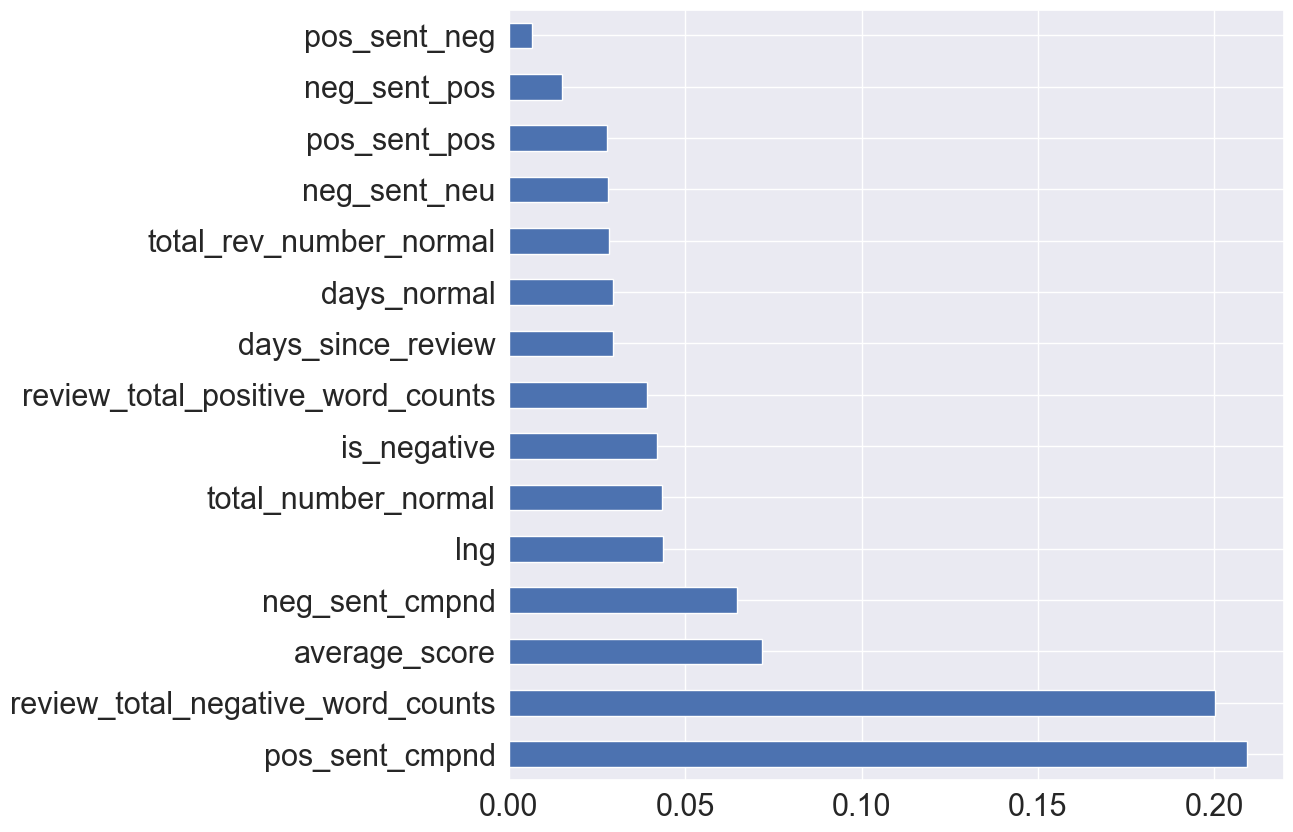

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

In [111]:
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample['reviewer_score'] = predict_submission
sample.to_csv('submission.csv', index=False)
sample.head(10)

,reviewer_score,id
0,8.620,488440
1,7.450,274649
2,7.955,374688
3,9.691,404352
4,9.370,451596
5,8.604,302161
6,7.969,317079
7,7.490,13963
8,8.579,159785
9,7.098,195089
